#One Time Run

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#loading data
data_raw = pd.read_excel('DATA-SVR.xlsx')
data_raw = data_raw.dropna(axis=1, how='all')

In [3]:
# Parameter SVR 
lamda   = 3
epsilon = 0.000001
cLR     = 0.0001
C       = 0.1
d       = 3
sigma   = 0.01

In [4]:
X = data_raw.iloc[:,2:8]
Y = data_raw['Selisih']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

In [5]:
def normalisasi(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data), scaler

X_train_scaled, XTrain_scaler = normalisasi(X_train)
y_train_scaled, YTrain_scaler = normalisasi(y_train.values.reshape(-1,1))
X_test_scaled = XTrain_scaler.transform(X_test)

In [6]:
def matrixHessian(data_1, data_2, lamda):
    xT = data_1.T
    hessian_x = np.dot(data_2, xT) + lamda**2
    return hessian_x

hessian = matrixHessian(X_train_scaled, X_train_scaled, lamda)
print("Hessian train shape", hessian.shape)

Hessian train shape (228, 228)


In [7]:
# Sequential Learning
# Goal : Nilai a* dan a
def sequentialLearning(data_train, datay_train, matrix_hessian, epsilon, C, cLR, maxIter = 100):
    z = 1
    
    a_star_init = list(np.zeros(data_train.shape[0]))
    a_init = list(np.zeros(data_train.shape[0]))

    hasilDalfaS = list(np.zeros(data_train.shape[0]))
    hasilDalfa = list(np.zeros(data_train.shape[0]))

    UpdateAlfaS = list(np.zeros(data_train.shape[0]))
    UpdateAlfa = list(np.zeros(data_train.shape[0]))

    baris = matrix_hessian.shape[0]
    kolom = matrix_hessian.shape[1]

    while z < maxIter:
        
        #Menghitung Nilai Error
        nilaiE = np.zeros(baris)
        for i in range(baris):
            total_error = 0
            for j in range(kolom):
                error = (a_star_init[j] - a_init[j]) * matrix_hessian[i][j]
                total_error += error
            nilaiE[i] = datay_train[i] - total_error

        #Menghitung Nilai Delta a* Delta a
        maxR = max(matrix_hessian.diagonal())
        gamma = cLR/maxR
        
        for i in range(baris):
            hasilDalfaS[i] = min(max(gamma*(nilaiE[i]-epsilon), -a_star_init[i]), C - a_star_init[i])
            hasilDalfa[i] = min(max(gamma*(-nilaiE[i]-epsilon), -a_init[i]), C - a_init[i])

        #Menghitung Nilai a* dan a
        for i in range(baris):
            UpdateAlfaS[i] = a_star_init[i] + hasilDalfaS[i]
            UpdateAlfa[i] = a_init[i] + hasilDalfa[i]
        
        a_star_init = UpdateAlfaS
        a_init = UpdateAlfa
        z+=1
        
        #Do Something with Trigger
        if max(abs(np.asarray(hasilDalfaS))) < epsilon and max(abs(np.asarray(hasilDalfa))) < epsilon:
            break

    return a_star_init, a_init

a_bintang, a_biasa = sequentialLearning(X_train_scaled, y_train_scaled, hessian, epsilon, C, cLR)
print("ini a bintang length\n", len(a_bintang))
print("ini a biasa length\n", len(a_biasa))

ini a bintang length
 228
ini a biasa length
 228


In [8]:
hessian_test = matrixHessian(X_train_scaled, X_test_scaled, lamda)

print("Hessian test shape", hessian_test.shape)

Hessian test shape (77, 228)


In [10]:
#Hitung hasil regresi
def fungsiRegresi(data, matrix_hessian, a_star, a):
    # print(matrix_hessian)
    baris = data.shape[0]
    sum_fx = list()
    
    for i in range(baris):
        sum_fx.append(sum([(a_star[j] - a[j])*matrix_hessian[i][j] for j in range(baris)]))
        
        # temp=[]
        # for j in range(baris):
        #     temp.append((a_star[j] - a[j])*matrix_hessian[i][j])
        # sum_fx.append(sum(temp))
    return sum_fx

result = fungsiRegresi(X_test_scaled, hessian_test, a_bintang, a_biasa)
len(result)

77

In [11]:
result_inverted = YTrain_scaler.inverse_transform(np.array(result).reshape(-1,1))

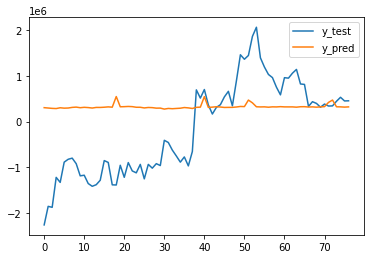

mape = 0.89 %


In [12]:
mape = mean_absolute_percentage_error(y_test,result_inverted)

#Plotting
def plot(y_test, y_pred):
    plt.plot(np.arange(len(y_test)),y_test)
    plt.plot(np.arange(len(y_pred)),y_pred)
    plt.legend(['y_test','y_pred'])
    plt.show()

plot(y_test,result_inverted)

print("mape = %.2f" % (mape),"%")

In [13]:
#loading data prediksi baru
data_baru = pd.read_excel('PREDIKSI-BARU.xlsx')
data_baru = data_baru.tail(77)

In [14]:
data_baru['Prediksi Selisih'] = result_inverted
data_baru['Prediksi Baru'] = data_baru['Prediksi Selisih']+data_baru['Data Aktual']

new_mape = mean_absolute_percentage_error(data_baru['Data Aktual'], data_baru['Prediksi Baru'])
print("mape = %.2f" % (new_mape),"%")

mape = 0.01 %


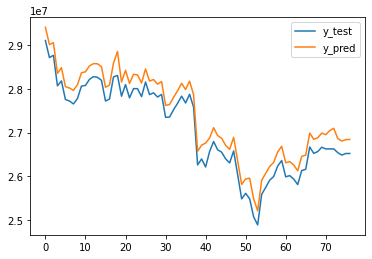

In [15]:
plot(data_baru['Data Aktual'], data_baru['Prediksi Baru'])

In [16]:
#predict new data

# Parameter SVR 
lamda   = 0.01
epsilon = 0.000001
cLR     = 0.0001
C       = 0.1
d       = 3
sigma   = 0.9


X_test_new = pd.read_excel('Xtrain-New.xlsx')
X_test_new = X_test_new.iloc[:,2:8]
X_test_new_scaled  = XTrain_scaler.transform(X_test_new)

In [17]:
hessian_new = matrixHessian(X_train_scaled, X_test_new_scaled, lamda)
hasil_new = fungsiRegresi(X_test_new_scaled, hessian_new, a_bintang, a_biasa)
hasil_new_unscaled = YTrain_scaler.inverse_transform(np.array(hasil_new).reshape(-1,1))

In [18]:
pd.DataFrame(hasil_new_unscaled)

,0
0,-3.325157e+06
1,-3.325045e+06
2,-3.324580e+06
3,-3.323579e+06
4,-3.322838e+06
